# Simple Deepfake Detection

These are the few experiments I ran, related to building a from scratch classifier for deep-fake detection, and then comparing it with some standard architectures for classification

## Imports

Imports are logically organized based on which phase the imports were used for
(Basically imported in-line, and brought them here)

In [ ]:
import os

import shutil
import random

from PIL import Image
import numpy as np

import torch
import torchvision
from torch.utils.data import DataLoader, Dataset
import albumentations as A
from albumentations.pytorch import ToTensorV2

import matplotlib.pyplot as plt

import torch.nn.functional as F
from torchsummary import summary

import torch.optim as optim
from torch.utils.tensorboard import SummaryWriter
import torchmetrics
from torchmetrics.classification import BinaryAccuracy, BinaryPrecision, BinaryRecall,BinaryF1Score, BinaryAUROC

import pandas as pd

In [ ]:
%pip install torchmetrics #Used torchmetrics for metrics, provides a nice API & device agnostics!

## Configuring the environment

Due to a major issue with my laptop, I had to transfer my working environment to Google Colab. As a result, we see some my manual configuration with colab's remote linux server below!

In [ ]:
ROOT_DIR = os.path.join("", "content/drive/MyDrive/Work/ML-in-Collab/WEC/Intell-Tasks/Task-1/Task-1A") #Ran in Google Colab :)
root = os.getenv("HOME")
os.chdir(root)
os.chdir("..")
os.chdir(ROOT_DIR)
os.listdir() #Verification in correct dir (initially has only train_images, test_images)

['train_images',
 'test_images',
 'sample_submission.csv',
 'Readme.md',
 '.ipynb_checkpoints',
 'final_test',
 'runs',
 'best_model_train_0.pth',
 'best_model_train_1_sus.pth',
 'predictions.csv',
 'best_model_fold_1.pth',
 'best_model_fold_2.pth',
 'predictions_resnet_18.csv',
 'best_model_fold_3.pth',
 'best_model_fold_4.pth',
 'best_model_train_resnet_18.pth']

## Data Exploration

### Checking with the file system

- First check the number of files present in each set
- We see that the dataset is nicely balanced! We will still augment our dataspace for better model tuning.

In [ ]:
path_train = os.path.join(os.getcwd(), 'train_images')
path_test = os.path.join(os.getcwd(), 'test_images')
path_train_real = os.path.join(path_train, 'real_train')
path_train_fake = os.path.join(path_train, 'fake_train')

count = 0
dir_paths = [path_train_real, path_train_fake, path_test]

for dir in dir_paths:
  for path in os.scandir(dir):
      if path.is_file():
          count += 1
  print(f'File Count in {dir}: {count}')
  count = 0
  #Was previously 800, 800, 400

File Count in /content/drive/MyDrive/Work/ML-in-Collab/WEC/Intell-Tasks/Task-1/Task-1A/train_images/real_train: 750
File Count in /content/drive/MyDrive/Work/ML-in-Collab/WEC/Intell-Tasks/Task-1/Task-1A/train_images/fake_train: 750
File Count in /content/drive/MyDrive/Work/ML-in-Collab/WEC/Intell-Tasks/Task-1/Task-1A/test_images: 400


**Important step: Creating a lock-test set**

- Essentially, we keep aside a small chunk of the training data pseudo-randomly, to mock a pre-Kaggle test set that we can locally test relevant metrics on, since this data will never be seen during training and validation.
- Relevant, since I enevntually implement cross-validation, so will effectively use the entire dataset

In [ ]:
#Commented out, so I don't move again XD
# #Make the final lock-test set

# # Set the seed
# random.seed(42)

# real_test_dir = 'final_test/real_test'
# fake_test_dir = 'final_test/fake_test'

# os.makedirs(real_test_dir, exist_ok=True)#No exception raised if dir alread does exist
# os.makedirs(fake_test_dir, exist_ok=True)

# #Remove 50 from each
# def move_random_files(source_dir, dest_dir, num_files):
#     files = os.listdir(source_dir)

#     selected_files = random.sample(files, num_files)

#     for file_name in selected_files:
#         src_file_path = os.path.join(source_dir, file_name)
#         dest_file_path = os.path.join(dest_dir, file_name)
#         shutil.move(src_file_path, dest_file_path)
#     print(f"Moved {num_files} files from {source_dir} to {dest_dir}")

# move_random_files(path_train_real, real_test_dir, 50)
# move_random_files(path_train_fake, fake_test_dir, 50)


Moved 50 files from /content/drive/MyDrive/Work/ML-in-Collab/WEC/Intell-Tasks/Task-1/Task-1A/train_images/real_train to final_test/real_test
Moved 50 files from /content/drive/MyDrive/Work/ML-in-Collab/WEC/Intell-Tasks/Task-1/Task-1A/train_images/fake_train to final_test/fake_test


Checking image sizes (do I have to be agnostic, or not?)
- Turns out, all of same size


In [ ]:
# Load all image dimensions
image_shapes = []
for dir in dir_paths:  # list of file paths from above
    for path in os.scandir(dir):
      img = Image.open(path)
      if len(image_shapes) == 0 or image_shapes.index(img.size):
        image_shapes.append(img.size)
      img.close()

# Convert to numpy array to analyze
print(f"All Image sizes: {image_shapes}")


All Image sizes: [(128, 128)]


### Abstracting out dataset

ImageFolder is implemented to be like [PyTorch's ImageFolder](https://pytorch.org/vision/main/generated/torchvision.datasets.ImageFolder.html), but handle some custom quirks, like interfacing with albumentations and specifc & deterministic ordering of class_to_idx dictionary

In [ ]:
class ImageFolder(Dataset):
    def __init__(self, root_dir, transform=None):

        self.root_dir = root_dir
        self.transform = transform
        self.classes, self.class_to_idx = self.get_classes(self.root_dir)
        self.samples = self.make_dataset()

    #Get list of all classes in the train/test set. This assumes that each class DOES NOT have sub-directories
    #Return list of classes, and mappings to number, as per Kaggle competition.
    def get_classes(self, dir):
        classes = [d.name for d in os.scandir(dir) if d.is_dir()]
        classes.sort(reverse=True)
        class_to_idx = {classes[i]: i for i, _ in enumerate(classes)}
        print(class_to_idx)
        return classes, class_to_idx

    #Use get_classes output to load all images together, with appropriate labelling!
    #Returns list of (image,label) tuple
    def make_dataset(self):
        images = []
        for class_name in self.classes:
            class_dir = os.path.join(self.root_dir, class_name)
            for root, _, fnames in sorted(os.walk(class_dir)):
                for fname in sorted(fnames):
                    path = os.path.join(root, fname)
                    item = (path, self.class_to_idx[class_name])
                    images.append(item)
        return images

    #Required override for torch.utils.data.Datset
    def __len__(self):
        return len(self.samples)

    #Getting an item from our list of training items
    #Apply an albumentations transform if present
    def __getitem__(self, idx):

        image_path, label = self.samples[idx]

        # Open the image with PIL; Albumentations takes in image as np, so transform it!
        image = Image.open(image_path)
        image = np.array(image)

        # Apply Albumentations transformations, if any
        if self.transform:
            augmented = self.transform(image=image)
            image = augmented['image']

        return image, label


### Augmentation step: [Albumentations](https://albumentations.ai/docs/api_reference/augmentations/transforms/)

Applied some simple transforms, could go further with changing brightness, some Gaussian noise, cropping, etc.

**Note to self**: Important to apply transfroms like Normalize, which significantly change image, on test data too!

In [ ]:
transform = A.Compose([
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
    ToTensorV2()
])

Test loading the datset, and dataloader

In [ ]:
# Dataset using ImageFolder -> Nice for Image classification!
vis_dataset = ImageFolder(root_dir='train_images', transform=transform)

vis_loader = DataLoader(vis_dataset, batch_size=16, shuffle=True)

# To verify class names and corresponding indices
print(f"Class to index mapping: {dataset.class_to_idx}")

{'real_train': 0, 'fake_train': 1}
Class to index mapping: {'real_train': 0, 'fake_train': 1}


### Visualizing the data

Rather than manually check each image using the file-system, a side-by-side comparison was easier to understand, and an interesting exercise to implement!

In [ ]:
def visualize_batch(images, labels, n_images=16, classes=None, de_norm=True):

    # Take first n images
    images = images[:n_images]
    labels = labels[:n_images]

    # Use denormalization, based on how we did above with albumentations. Comment out if you don't use normalization above.
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])

    # Number of columns and rows for subplots
    n_cols = int(np.sqrt(n_images))
    n_rows = int(np.ceil(n_images / n_cols))


    fig, axes = plt.subplots(n_rows, n_cols, figsize=(12, 12))
    axes = axes.flatten()

    for i in range(n_images):
        # Unnormalize the image
        image = images[i].permute(1, 2, 0).numpy() #plt expects images as (H, W, C), so permute dimensions
        if de_norm:
          image = (image * std + mean).clip(0, 1)  # Chop to [0, 1] -> Had to search this...

        # Plot image
        axes[i].imshow(image)

        title = f"Image: {'Real' if labels[i].item() == 0 else 'Fake'}"

        axes[i].set_title(title)
        axes[i].axis('off')

    # Remove any extra axes if n_images is not a perfect square
    for j in range(n_images, len(axes)):
        axes[j].axis('off')

    #Tight layout: was scrolling and found this: https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.tight_layout.html
    plt.tight_layout()
    plt.show()


Visualize

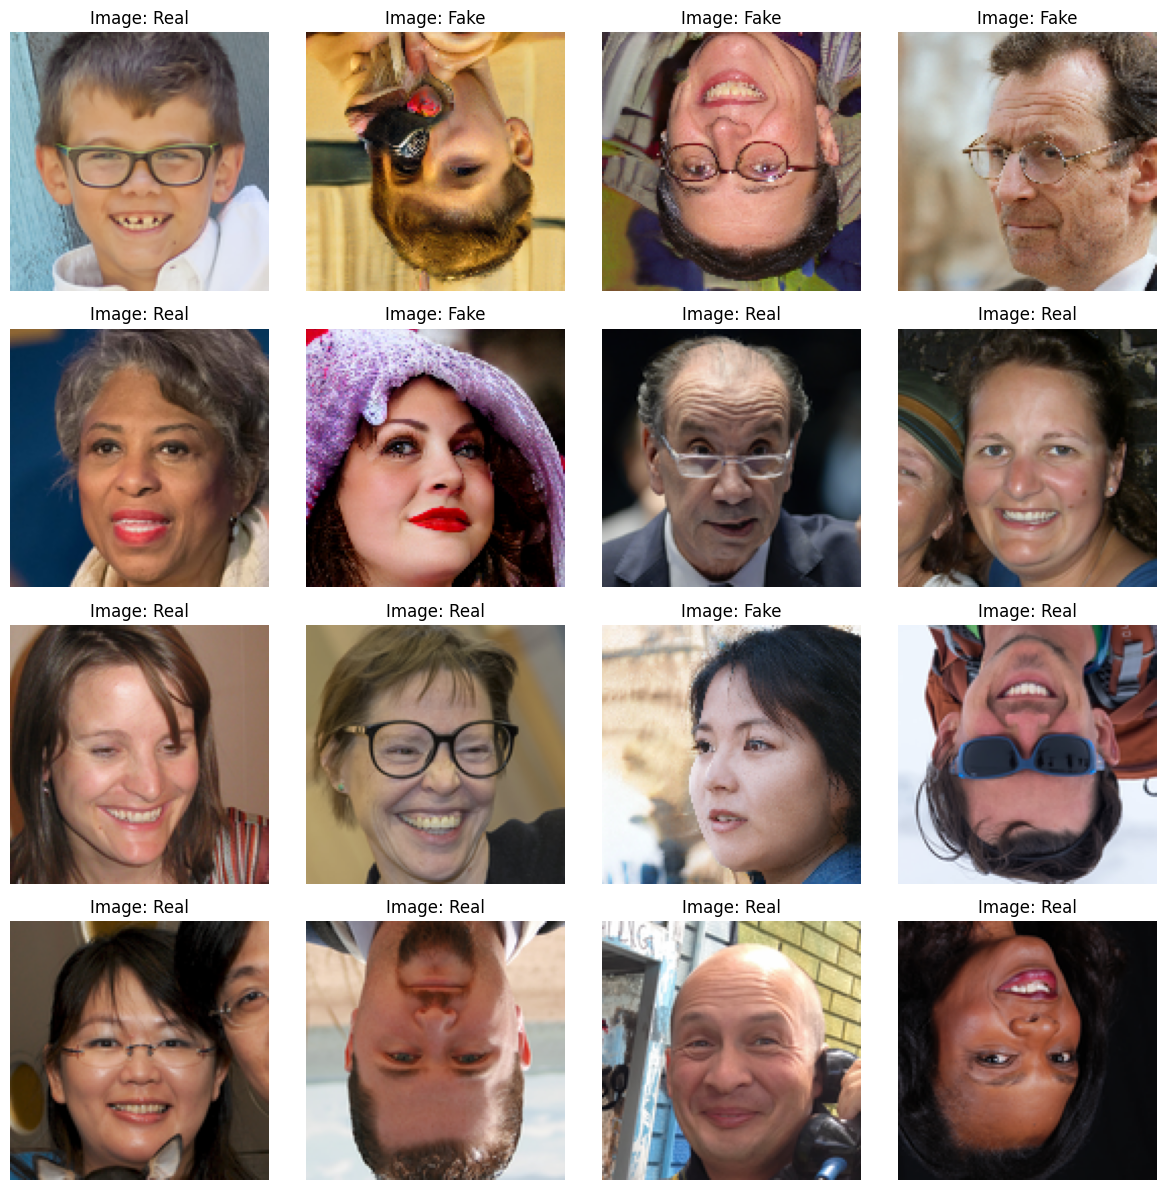

In [ ]:
for images, labels in vis_loader:
    visualize_batch(images, labels, n_images=16, de_norm=True)
    break

## Classifier Architectures

Had done initial trials with super small architectures, but the shift occurred. Didn't have much success, so tried to implement block like-structure present in all modern models
- Did calculations for keeping track, because I kept forgetting. Just used multiple of 2 :)

In [ ]:
class Classifier1(nn.Module):
    def __init__(self):  # Binary classification
        super(Classifier1, self).__init__()

        # Block 1: Conv + BatchNorm + MaxPool
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1)  # (3, 128, 128) -> (32, 128, 128)
        self.bn1 = nn.BatchNorm2d(32)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)  # (32, 128, 128) -> (32, 64, 64)

        # Block 2: Conv + BatchNorm + ReLU + MaxPool
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1)  # (32, 64, 64) -> (64, 64, 64)
        self.bn2 = nn.BatchNorm2d(64)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)  # (64, 64, 64) -> (64, 32, 32)

        # Block 3: Conv + BatchNorm + ReLU + MaxPool
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1)  # (64, 32, 32) -> (128, 32, 32)
        self.bn3 = nn.BatchNorm2d(128)
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)  # (128, 32, 32) -> (128, 16, 16)

        # Block 4: Conv + BatchNorm + ReLU + MaxPool
        self.conv4 = nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding=1)  # (128, 16, 16) -> (256, 16, 16)
        self.bn4 = nn.BatchNorm2d(256)
        self.pool4 = nn.MaxPool2d(kernel_size=2, stride=2)  # (256, 16, 16) -> (256, 8, 8)

        # Fully Connected Layers
        self.fc1 = nn.Linear(256 * 8 * 8, 512)  # Flattened layer to 512 neurons
        self.bn_fc1 = nn.BatchNorm1d(512)
        self.fc2 = nn.Linear(512, 128)
        self.bn_fc2 = nn.BatchNorm1d(128)
        self.fc3 = nn.Linear(128, 1)  # Output for binary classification (1 node) -> would make a vector for multi-class

        # LeakyReLU instead of standard ReLU (optional)
        self.leaky_relu = nn.LeakyReLU(negative_slope=0.01)

    def forward(self, x):
        # Block 1
        x = self.pool1((self.bn1(self.conv1(x))))
        # Block 2
        x = self.pool2(F.relu(self.bn2(self.conv2(x))))
        # Block 3
        x = self.pool3((self.bn3(self.conv3(x))))
        # Block 4
        x = self.pool4(F.relu(self.bn4(self.conv4(x))))

        # Flatten the output for fc layers
        x = x.view(x.size(0), -1)

        # Fully connected layers with Leaky ReLU
        x = self.leaky_relu(self.bn_fc1(self.fc1(x)))
        x = self.leaky_relu(self.bn_fc2(self.fc2(x)))

        # Final layer (loss functon/criterion present in train loop)
        x = self.fc3(x)

        return x


Total model weights: 8.8M (exploded due to first FC layer)

In [ ]:
classifier = Classifier1()
device = ("cuda" if torch.cuda.is_available() else "cpu")
classifier.to(device)

# Print the model summary
summary(classifier, input_size=(3, 128, 128))  # Input size is (C, H, W)


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 128, 128]             896
       BatchNorm2d-2         [-1, 32, 128, 128]              64
         MaxPool2d-3           [-1, 32, 64, 64]               0
            Conv2d-4           [-1, 64, 64, 64]          18,496
       BatchNorm2d-5           [-1, 64, 64, 64]             128
         MaxPool2d-6           [-1, 64, 32, 32]               0
            Conv2d-7          [-1, 128, 32, 32]          73,856
       BatchNorm2d-8          [-1, 128, 32, 32]             256
         MaxPool2d-9          [-1, 128, 16, 16]               0
           Conv2d-10          [-1, 256, 16, 16]         295,168
      BatchNorm2d-11          [-1, 256, 16, 16]             512
        MaxPool2d-12            [-1, 256, 8, 8]               0
           Linear-13                  [-1, 512]       8,389,120
      BatchNorm1d-14                  [

To compare the model, also trained ResNet-18, ResNet-50 from scratch as well!

In [ ]:
class ResNet18BinaryClassifier(nn.Module):
    def __init__(self):
        super(ResNet18BinaryClassifier, self).__init__()

        # Load the ResNet18 model
        self.resnet = torchvision.models.resnet18(weights=None)

        #Searched this up...
        # Modify the last fully connected layer to output 1 value
        num_features = self.resnet.fc.in_features  # Get the number of input features for the final layer
        self.resnet.fc = nn.Linear(num_features, 1)  # Replace the final layer with a binary classifier (1 output)

    def forward(self, x):
        return self.resnet(x)

Total model weights: 11.1M params

In [ ]:
resnet18 = ResNet18BinaryClassifier()  # We do not load pre-trained weights
device = ("cuda" if torch.cuda.is_available() else "cpu")
resnet18.to(device)

# Print the model summary
summary(resnet18, input_size=(3, 128, 128))  # Input size is (channels, height, width)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 64, 64]           9,408
       BatchNorm2d-2           [-1, 64, 64, 64]             128
              ReLU-3           [-1, 64, 64, 64]               0
         MaxPool2d-4           [-1, 64, 32, 32]               0
            Conv2d-5           [-1, 64, 32, 32]          36,864
       BatchNorm2d-6           [-1, 64, 32, 32]             128
              ReLU-7           [-1, 64, 32, 32]               0
            Conv2d-8           [-1, 64, 32, 32]          36,864
       BatchNorm2d-9           [-1, 64, 32, 32]             128
             ReLU-10           [-1, 64, 32, 32]               0
       BasicBlock-11           [-1, 64, 32, 32]               0
           Conv2d-12           [-1, 64, 32, 32]          36,864
      BatchNorm2d-13           [-1, 64, 32, 32]             128
             ReLU-14           [-1, 64,

Total model weights: 23M params

In [ ]:
class ResNet50BinaryClassifier(nn.Module):
    def __init__(self):
        super(ResNet50BinaryClassifier, self).__init__()

        # Load the ResNet50 model
        self.resnet = torchvision.models.resnet50(weights=None)

        # Modify the last fully connected layer to output 1 value (for binary classification)
        num_features = self.resnet.fc.in_features  # Get the number of input features for the final layer
        self.resnet.fc = nn.Linear(num_features, 1)  # Replace the final layer with a binary classifier (1 output)

    def forward(self, x):
        return self.resnet(x)

In [ ]:
resnet50 = ResNet50BinaryClassifier()  # We do not load pre-trained weights
device = ("cuda" if torch.cuda.is_available() else "cpu")
resnet50.to(device)

# Print the model summary
summary(resnet50, input_size=(3, 128, 128))  # Input size is (channels, height, width)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 64, 64]           9,408
       BatchNorm2d-2           [-1, 64, 64, 64]             128
              ReLU-3           [-1, 64, 64, 64]               0
         MaxPool2d-4           [-1, 64, 32, 32]               0
            Conv2d-5           [-1, 64, 32, 32]           4,096
       BatchNorm2d-6           [-1, 64, 32, 32]             128
              ReLU-7           [-1, 64, 32, 32]               0
            Conv2d-8           [-1, 64, 32, 32]          36,864
       BatchNorm2d-9           [-1, 64, 32, 32]             128
             ReLU-10           [-1, 64, 32, 32]               0
           Conv2d-11          [-1, 256, 32, 32]          16,384
      BatchNorm2d-12          [-1, 256, 32, 32]             512
           Conv2d-13          [-1, 256, 32, 32]          16,384
      BatchNorm2d-14          [-1, 256,

## Interface for Training

I desired a reproducable framework for training at later dates, where I can _try_ to use different training techniques: like cross-val! So, spent some time searching and trying to create some functions to separate the logic.

### Training an Epoch
I will probably slightly change the code to optionally take in metrics: here I just used all of them. Expected them from [torchmetrics](https://lightning.ai/docs/torchmetrics/stable/)

In [ ]:
def train_one_epoch(model, train_loader, optimizer, device, accuracy_metric, precision_metric, recall_metric, f1_metric, roc_auc_metric):
    model.train()  # Set the model to training mode
    running_loss = 0.0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        # Always zero out the gradients, since torch gradients are additive
        optimizer.zero_grad()

        # Forward pass
        logits = model(images)
        loss = F.binary_cross_entropy_with_logits(logits, labels.unsqueeze(1).float())  # BCEWithLogitsLoss: Criterion used!!!
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        # Update metrics
        preds = (torch.sigmoid(logits).squeeze() >= 0.5).float()  # Convert logits to binary predictions
        accuracy_metric(preds, labels.int())
        precision_metric(preds, labels.int())
        recall_metric(preds, labels.int())
        f1_metric(preds, labels.int())
        roc_auc_metric(preds, labels.int())

    return running_loss / len(train_loader)

### Evaluating the Model
Pretty similar, just make sure to inference only.

In [ ]:
def validate_model(model, val_loader, device, accuracy_metric, precision_metric, recall_metric, f1_metric, roc_auc_metric):
    model.eval()  # Set the model to evaluation mode
    running_loss = 0.0

    with torch.inference_mode():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            logits = model(images)

            # Compute the loss
            loss = F.binary_cross_entropy_with_logits(logits, labels.unsqueeze(1).float())
            running_loss += loss.item()

            # Update metrics
            preds = (torch.sigmoid(logits).squeeze() >= 0.5).float()  # Convert logits to binary predictions
            accuracy_metric(preds, labels.int())
            precision_metric(preds, labels.int())
            recall_metric(preds, labels.int())
            f1_metric(preds, labels.int())
            roc_auc_metric(preds, labels.int())

    avg_loss = running_loss / len(val_loader)

    # Get computed metrics
    metrics = {
        'accuracy': accuracy_metric.compute().item(),
        'precision': precision_metric.compute().item(),
        'recall': recall_metric.compute().item(),
        'f1': f1_metric.compute().item(),
        'roc_auc': roc_auc_metric.compute().item(),
    }

    # Reset metrics for next epoch
    accuracy_metric.reset()
    precision_metric.reset()
    recall_metric.reset()
    f1_metric.reset()
    roc_auc_metric.reset()

    return avg_loss, metrics

## Training and evaluation, with metrics to be incorporated with Tensorboard

The tensorboard part will be done, when back on my system. For now, searched up what I would have to do for those parts.

In [ ]:
# Define the training and validation loop
def train_and_evaluate_model(model, train_loader, val_loader, num_epochs=20, learning_rate=1e-3, model_save_path='best_model.pth', exp_name='experiment1'):
    # Set up the device
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)

    # Define the optimizer and learning rate scheduler
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=5)

    # TensorBoard writer: searched this up...
    writer = SummaryWriter(log_dir=f'runs/{exp_name}')

    # Initialize metrics
    accuracy_metric = BinaryAccuracy().to(device)
    precision_metric = BinaryPrecision().to(device)
    recall_metric = BinaryRecall().to(device)
    f1_metric = BinaryF1Score().to(device)
    roc_auc_metric = BinaryAUROC().to(device)

    # Initialize variables for saving the best model
    best_f1 = 0.0

    # Training and evaluation
    for epoch in range(num_epochs):
        train_loss = train_one_epoch(model, train_loader, optimizer, device, accuracy_metric, precision_metric, recall_metric, f1_metric, roc_auc_metric)
        val_loss, metrics = validate_model(model, val_loader, device, accuracy_metric, precision_metric, recall_metric, f1_metric, roc_auc_metric)

        # Log metrics: Searched this up...
        writer.add_scalar('Loss/train', train_loss, epoch)
        writer.add_scalar('Loss/val', val_loss, epoch)
        writer.add_scalar('Metrics/Accuracy', metrics['accuracy'], epoch)
        writer.add_scalar('Metrics/Precision', metrics['precision'], epoch)
        writer.add_scalar('Metrics/Recall', metrics['recall'], epoch)
        writer.add_scalar('Metrics/F1', metrics['f1'], epoch)
        writer.add_scalar('Metrics/ROC_AUC', metrics['roc_auc'], epoch)

        print(f'Epoch [{epoch + 1}/{num_epochs}], Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, '
              f'Accuracy: {metrics["accuracy"]:.4f}, F1 Score: {metrics["f1"]:.4f}')

        # Save the model if the F1 score is the best we've seen so far
        if metrics['f1'] > best_f1:
            print(f'New best F1 score: {metrics["f1"]:.4f}. Saving model...')
            torch.save(model.state_dict(), model_save_path)
            best_f1 = metrics['f1']

        # Step the scheduler based on the validation loss -> this is only since used ReduceLROnPlateau scheduler
        scheduler.step(val_loss)

    writer.close()
    print(f"Best model saved with F1 score: {best_f1:.4f}")

## Extending: K-Fold Cross Validation
With a dataset of only 800 images, I felt it was important to use all the data for training, without overfitting. So, I tried to implement k-fold cross-val, suing the functions above

In [ ]:
def k_fold_cross_validation(model, dataset, k=5, num_epochs=20, learning_rate=1e-3, exp_name='experiment1'):
    fold_size = len(dataset) // k
    indices = np.random.permutation(len(dataset))

    for fold in range(k):
        print(f"\nFold {fold + 1}/{k}")

        # Create train and validation indices
        val_indices = indices[fold * fold_size:(fold + 1) * fold_size]
        train_indices = np.concatenate((indices[:fold * fold_size], indices[(fold + 1) * fold_size:]))

        train_subset = torch.utils.data.Subset(dataset, train_indices)
        val_subset = torch.utils.data.Subset(dataset, val_indices)

        train_loader = DataLoader(train_subset, batch_size=32, shuffle=True)
        val_loader = DataLoader(val_subset, batch_size=32, shuffle=False)

        # Train and evaluate the model
        train_and_evaluate_model(model, train_loader, val_loader, num_epochs, learning_rate, model_save_path=f'best_model_fold_{fold + 1}.pth')

## Training the Models
- I have shown the final training for the custom classifier.
- I decided to conduct same number of epochs and k-vals for ResNet models, based on this.
- This was a mistake, since obviously a model with greater params will take longer to converge, and so heavily underfit ResNet-50 (could also play with scheduler for ResNet-50 especially, for faster convergence)

In [ ]:
dataset = ImageFolder('train_images', transform=transform)
model = Classifier1()
k_fold_cross_validation(model, dataset, k=5, num_epochs=5, learning_rate=1e-3, exp_name='experiment1')

{'real_train': 0, 'fake_train': 1}

Fold 1/5
Epoch [1/5], Train Loss: 0.4258, Val Loss: 1.5427, Accuracy: 0.7447, F1 Score: 0.7079
New best F1 score: 0.7079. Saving model...
Epoch [2/5], Train Loss: 0.2020, Val Loss: 0.3474, Accuracy: 0.9087, F1 Score: 0.9075
New best F1 score: 0.9075. Saving model...
Epoch [3/5], Train Loss: 0.1248, Val Loss: 0.1814, Accuracy: 0.9587, F1 Score: 0.9589
New best F1 score: 0.9589. Saving model...
Epoch [4/5], Train Loss: 0.1216, Val Loss: 0.0656, Accuracy: 0.9627, F1 Score: 0.9625
New best F1 score: 0.9625. Saving model...
Epoch [5/5], Train Loss: 0.0882, Val Loss: 0.0925, Accuracy: 0.9700, F1 Score: 0.9698
New best F1 score: 0.9698. Saving model...
Best model saved with F1 score: 0.9698

Fold 2/5
Epoch [1/5], Train Loss: 0.1087, Val Loss: 0.0728, Accuracy: 0.9653, F1 Score: 0.9653
New best F1 score: 0.9653. Saving model...
Epoch [2/5], Train Loss: 0.0809, Val Loss: 0.1841, Accuracy: 0.9647, F1 Score: 0.9641
Epoch [3/5], Train Loss: 0.0735, Val Loss: 0.2

In [ ]:
dataset = ImageFolder('train_images', transform=transform)
model_18 = ResNet18BinaryClassifier()
k_fold_cross_validation(model_18, dataset, k=5, num_epochs=5, learning_rate=1e-3, exp_name='experiment18')

{'real_train': 0, 'fake_train': 1}

Fold 1/5
Epoch [1/5], Train Loss: 0.7771, Val Loss: 0.7873, Accuracy: 0.5133, F1 Score: 0.5565
New best F1 score: 0.5565. Saving model...
Epoch [2/5], Train Loss: 0.7051, Val Loss: 0.7095, Accuracy: 0.5193, F1 Score: 0.4912
Epoch [3/5], Train Loss: 0.6365, Val Loss: 0.8166, Accuracy: 0.6193, F1 Score: 0.5774
New best F1 score: 0.5774. Saving model...
Epoch [4/5], Train Loss: 0.5455, Val Loss: 1.1287, Accuracy: 0.6967, F1 Score: 0.6834
New best F1 score: 0.6834. Saving model...
Epoch [5/5], Train Loss: 0.3509, Val Loss: 1.7225, Accuracy: 0.8053, F1 Score: 0.8180
New best F1 score: 0.8180. Saving model...
Best model saved with F1 score: 0.8180

Fold 2/5
Epoch [1/5], Train Loss: 0.3498, Val Loss: 0.3859, Accuracy: 0.8400, F1 Score: 0.8429
New best F1 score: 0.8429. Saving model...
Epoch [2/5], Train Loss: 0.2098, Val Loss: 0.9032, Accuracy: 0.8740, F1 Score: 0.8824
New best F1 score: 0.8824. Saving model...
Epoch [3/5], Train Loss: 0.1467, Val Loss: 0.2

In [ ]:
dataset = ImageFolder('train_images', transform=transform)
model_50 = ResNet50BinaryClassifier()
k_fold_cross_validation(model_50, dataset, k=5, num_epochs=5, learning_rate=1e-3)

{'real_train': 0, 'fake_train': 1}

Fold 1/5
Epoch [1/5], Train Loss: 0.8355, Val Loss: 1.2678, Accuracy: 0.4980, F1 Score: 0.4368
New best F1 score: 0.4368. Saving model...
Epoch [2/5], Train Loss: 0.7205, Val Loss: 0.7371, Accuracy: 0.5267, F1 Score: 0.4678
New best F1 score: 0.4678. Saving model...
Epoch [3/5], Train Loss: 0.8082, Val Loss: 1.8134, Accuracy: 0.5600, F1 Score: 0.5352
New best F1 score: 0.5352. Saving model...
Epoch [4/5], Train Loss: 0.7241, Val Loss: 0.6940, Accuracy: 0.5540, F1 Score: 0.5184
Epoch [5/5], Train Loss: 0.7072, Val Loss: 0.7268, Accuracy: 0.5480, F1 Score: 0.5654
New best F1 score: 0.5654. Saving model...
Best model saved with F1 score: 0.5654

Fold 2/5
Epoch [1/5], Train Loss: 0.7459, Val Loss: 1.5762, Accuracy: 0.5113, F1 Score: 0.5142
New best F1 score: 0.5142. Saving model...
Epoch [2/5], Train Loss: 0.7134, Val Loss: 0.7783, Accuracy: 0.5053, F1 Score: 0.5640
New best F1 score: 0.5640. Saving model...
Epoch [3/5], Train Loss: 0.7223, Val Loss: 0.7

Pretty acceptable performance for Classifier1 and ResNet-18, but little bit dumb on my part for ResNet-50

## Inference on Lock-Test set
Now to test if the models actually learnt good features! Once again, tried to abstract some the functions involved

### Evaluater for test set
Pretty simialr to Validater!

In [ ]:
def evaluate_on_test_data(model, test_loader, device):
    model.eval()  # Set the model to evaluation mode
    model.to(device)

    # Initialize metrics
    accuracy_metric = BinaryAccuracy().to(device)
    precision_metric = BinaryPrecision().to(device)
    recall_metric = BinaryRecall().to(device)
    f1_metric = BinaryF1Score().to(device)

    with torch.inference_mode():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)

            # Forward pass
            logits = model(images)
            preds = (torch.sigmoid(logits).squeeze() >= 0.5).float()  # Convert to float 0.0 or 1.0

            # Update metrics
            accuracy_metric(preds, labels.int())
            precision_metric(preds, labels.int())
            recall_metric(preds, labels.int())
            f1_metric(preds, labels.int())

    # Get computed metrics
    accuracy = accuracy_metric.compute().item()
    precision = precision_metric.compute().item()
    recall = recall_metric.compute().item()
    f1 = f1_metric.compute().item()

    print(f"Test Metrics - Accuracy: {accuracy:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}, F1 Score: {f1:.4f}")

    # Reset metrics (optional, if you want to reuse them)
    accuracy_metric.reset()
    precision_metric.reset()
    recall_metric.reset()
    f1_metric.reset()

    return accuracy, precision, recall, f1


### Function for loading model
Used this, since I load a model in several places
Note: should also incorporate this in training, if I would like to resume from somewhere!!!

In [ ]:
# Load the best model
def load_model(model, model_weights_path, device):
    model.load_state_dict(torch.load(model_weights_path, map_location=device, weights_only=True))
    return model

### Test Loader function
Once again due to repetition; strictly necessary transforms used, although could have used other augmentations for better testing

In [ ]:
# Create the test data loader
def create_test_loader(test_dir, batch_size=32):
    test_transforms = A.Compose([
        A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
        ToTensorV2(),
    ])
    test_dataset = ImageFolder(root_dir=test_dir, transform=test_transforms)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
    return test_loader

### Testing time

In [ ]:
test_dir = 'final_test'
batch_size = 32
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Assuming CNNClassifier is the model class you defined earlier
model_classifier1_test = Classifier1()
model_classifier1_test = load_model(model_classifier1_test, 'best_model_train_classifier1.pth', device)

# Create the test loader
test_loader = create_test_loader(test_dir, batch_size)

# Evaluate the model on the test set
evaluate_on_test_data(model_classifier1_test, test_loader, device)

{'real_test': 0, 'fake_test': 1}
Test Metrics - Accuracy: 1.0000, Precision: 1.0000, Recall: 1.0000, F1 Score: 1.0000


(1.0, 1.0, 1.0, 1.0)

In [ ]:
test_dir = 'final_test'
batch_size = 32
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model_18_test = ResNet18BinaryClassifier()
model_18_test = load_model(model_18_test, 'best_model_train_resnet_18.pth', device)

# Create the test loader
test_loader = create_test_loader(test_dir, batch_size)

# Evaluate the model on the test set
evaluate_on_test_data(model_18_test, test_loader, device)

{'real_test': 0, 'fake_test': 1}
Test Metrics - Accuracy: 0.9900, Precision: 1.0000, Recall: 0.9800, F1 Score: 0.9899


(0.9900000095367432, 1.0, 0.9800000190734863, 0.9898989796638489)

In [ ]:
test_dir = 'final_test'
batch_size = 32
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model_50_test = ResNet50BinaryClassifier()
model_50_test = load_model(model_50_test, 'best_model_train_resnet_50.pth', device)

# Create the test loader
test_loader = create_test_loader(test_dir, batch_size)

# Evaluate the model on the test set
evaluate_on_test_data(model_50_test, test_loader, device)

{'real_test': 0, 'fake_test': 1}
Test Metrics - Accuracy: 0.5300, Precision: 0.5161, Recall: 0.9600, F1 Score: 0.6713


(0.5299999713897705,
 0.5161290168762207,
 0.9599999785423279,
 0.6713286638259888)

## Submit to Kaggle
The last step :)

### TestImageDataset
Slightly changed what was returned (needed IDs)

In [ ]:
class TestImageDataset(Dataset):
    def __init__(self, image_dir, transform=None):
        self.image_dir = image_dir
        self.transform = transform
        self.image_filenames = sorted(os.listdir(image_dir))

    def __len__(self):
        return len(self.image_filenames)

    def __getitem__(self, idx):
        img_name = self.image_filenames[idx]
        img_path = os.path.join(self.image_dir, img_name)
        image = Image.open(img_path)
        image = np.array(image)

        if self.transform:
            transformed = self.transform(image=image)
            image = transformed['image']

        image_id = img_name.split('_')[-1].split('.')[0]  # Extract ID before the file extension

        return image, image_id

### Inference function
Added pushing results to pd Dataframe

In [ ]:
def run_inference_and_save(model, test_loader, device, output_csv='predictions.csv'):
    model.eval()  # Set model to evaluation mode
    model.to(device)

    results = []

    with torch.inference_mode():
        for images, image_ids in test_loader:
            images = images.to(device)

            # Forward pass
            logits = model(images)
            preds = (torch.sigmoid(logits).squeeze() >= 0.5).float()  # Predictions (0 or 1)

            # Collect the results
            for img_id, pred in zip(image_ids, preds):
                results.append({'ID': img_id, 'TARGET': int(pred.item())})

    # Save results to a CSV file
    df = pd.DataFrame(results)
    df.to_csv(output_csv, index=False)
    print(f"Predictions saved to {output_csv}")

In [ ]:
test_dir = 'test_images'
batch_size = 32
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model_classifier1_send = Classifier1()
model_classifier1_send = load_model(model_classifier1_send, 'best_model_train_classifier1.pth', device)
test_loader = create_test_loader(test_dir, batch_size)

# Run inference and save predictions
run_inference_and_save(model_classifier1_send, test_loader, device, output_csv='predictions_classifier1.csv')

In [ ]:
test_dir = 'test_images'
batch_size = 32
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model_18_send = ResNet18BinaryClassifier()
model_18_send = load_model(model_18_send, 'best_model_train_resnet_18.pth', device)
test_loader = create_test_loader(test_dir, batch_size)

# Run inference and save predictions
run_inference_and_save(model_18_send, test_loader, device, output_csv='predictions_resnet_18.csv')


Predictions saved to predictions_resnet_18.csv


In [ ]:
test_dir = 'test_images'
batch_size = 32
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model_50_send = ResNet18BinaryClassifier()
model_50_send = load_model(model_50_send, 'best_model_train_resnet_50.pth', device)
test_loader = create_test_loader(test_dir, batch_size)

# Run inference and save predictions
run_inference_and_save(model_50_send, test_loader, device, output_csv='predictions_resnet_18.csv')
